In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize
import theano.tensor as tt

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300 
np.random.seed(5201)

In [3]:
half_lenght = 3.66  # meters
penalty_point = 11  # meters
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))


ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ) 
        p_goal = pm.Deterministic("p_goal", 2 * Phi(tt.arctan(half_lenght / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

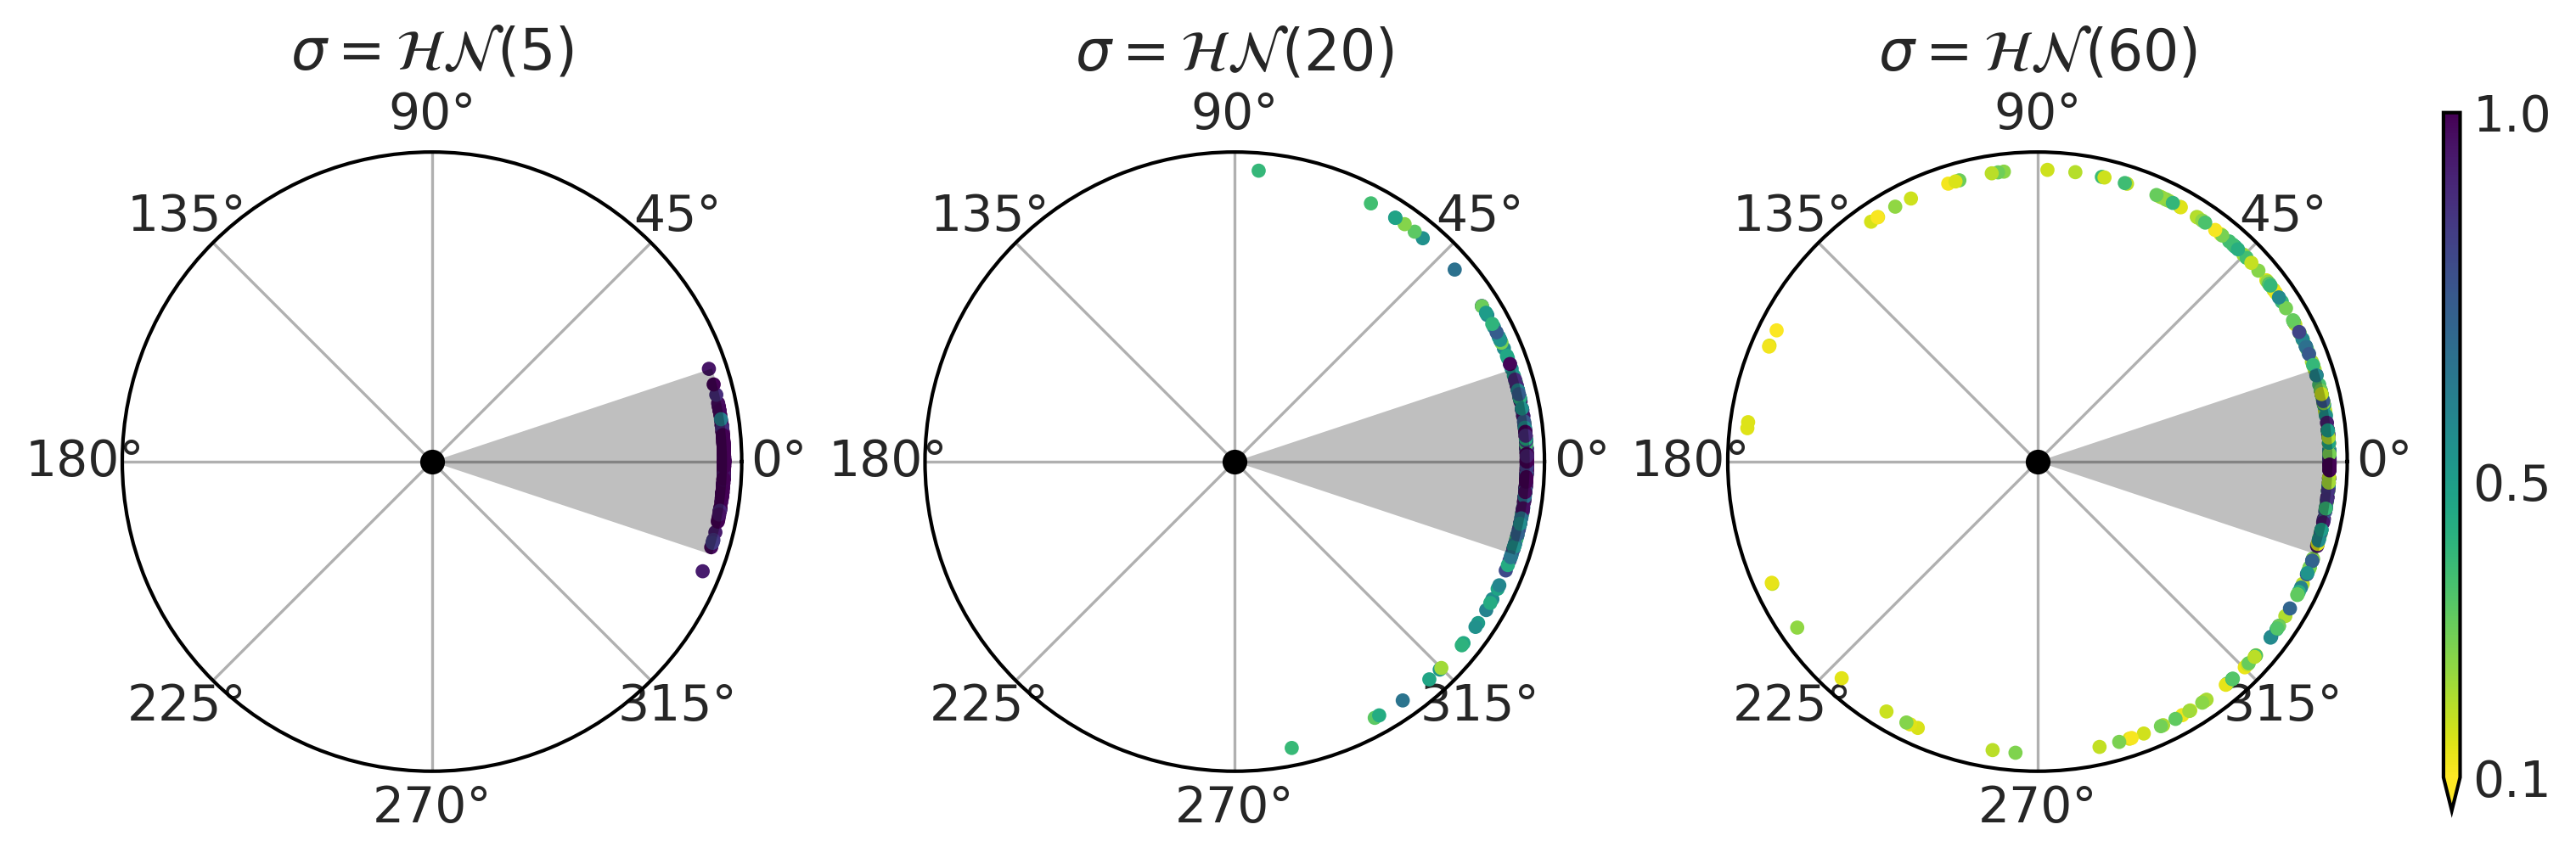

In [4]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_lenght/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps["p_goal"] > 0.1
    cax = ax.scatter(pps["α"][cutoff], np.ones_like(pps["α"][cutoff]), c=pps["p_goal"][cutoff],
               marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)
    
plt.savefig("img/chp02/prior_predictive_distributions_00.png", bbox_inches="tight")

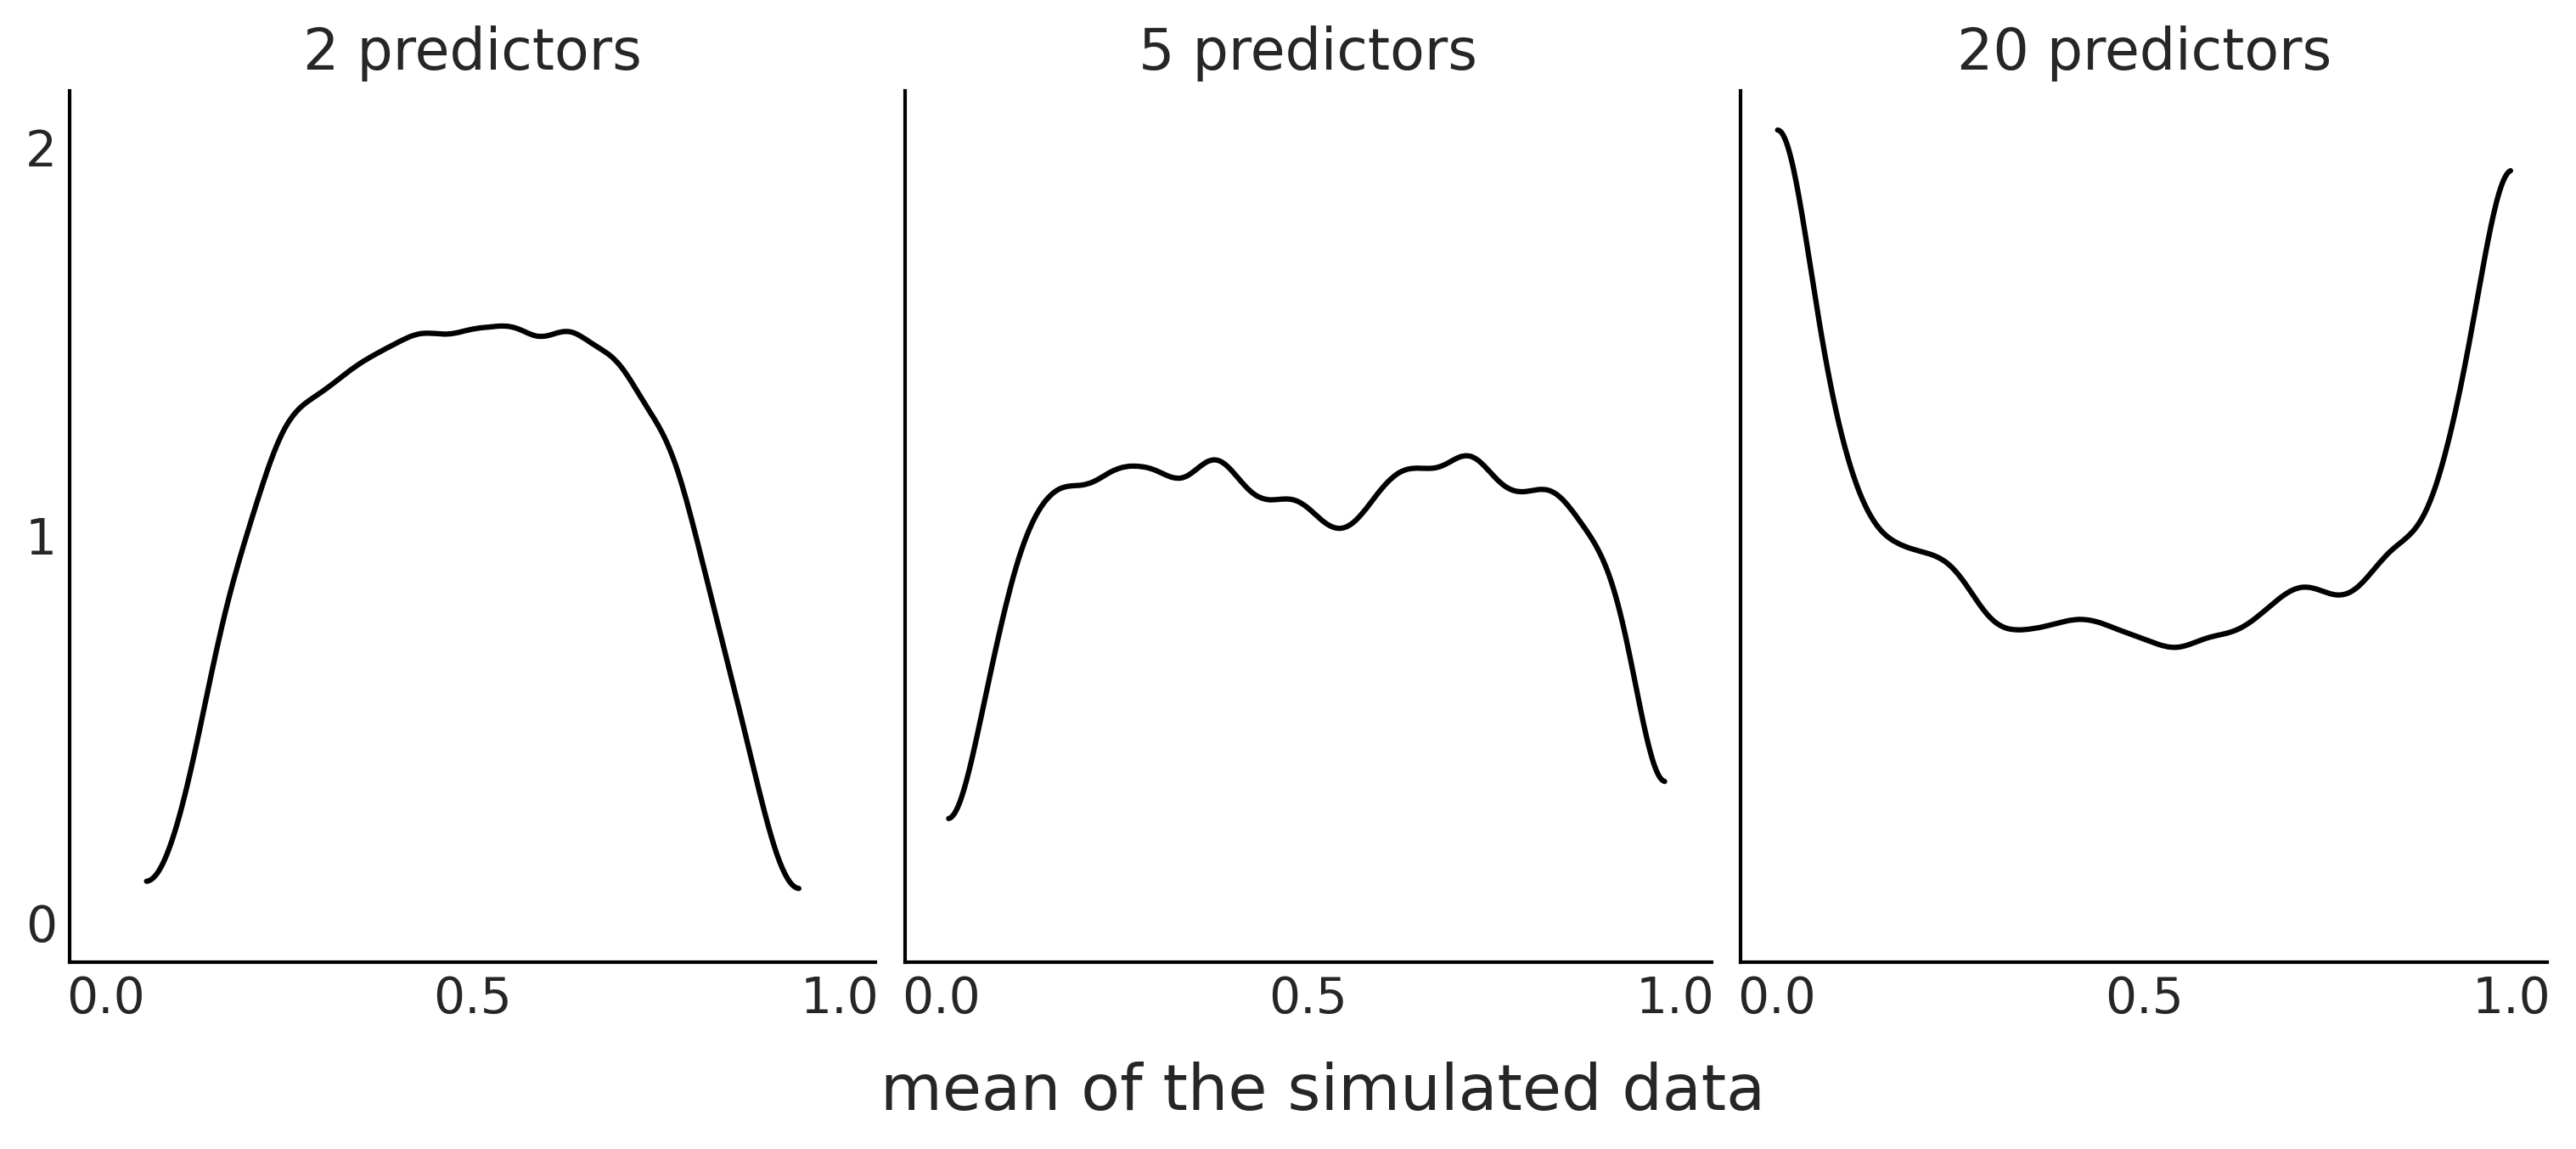

In [5]:
from scipy.special import expit
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True,  sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 5, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax)
    ax.set_title(f"{dim} predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])
    
fig.text(0.34, -0.075, size=18, s="mean of the simulated data")
plt.savefig("img/chp02/prior_predictive_distributions_01.png", bbox_inches="tight")

In [6]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=θ, observed=Y)
    trace_b = pm.sample(1000)

<ipython-input-6-2e8727eee630>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_b = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [7]:
pred_dist = pm.sample_posterior_predictive(trace_b, 1000, model=model)["y_obs"]

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


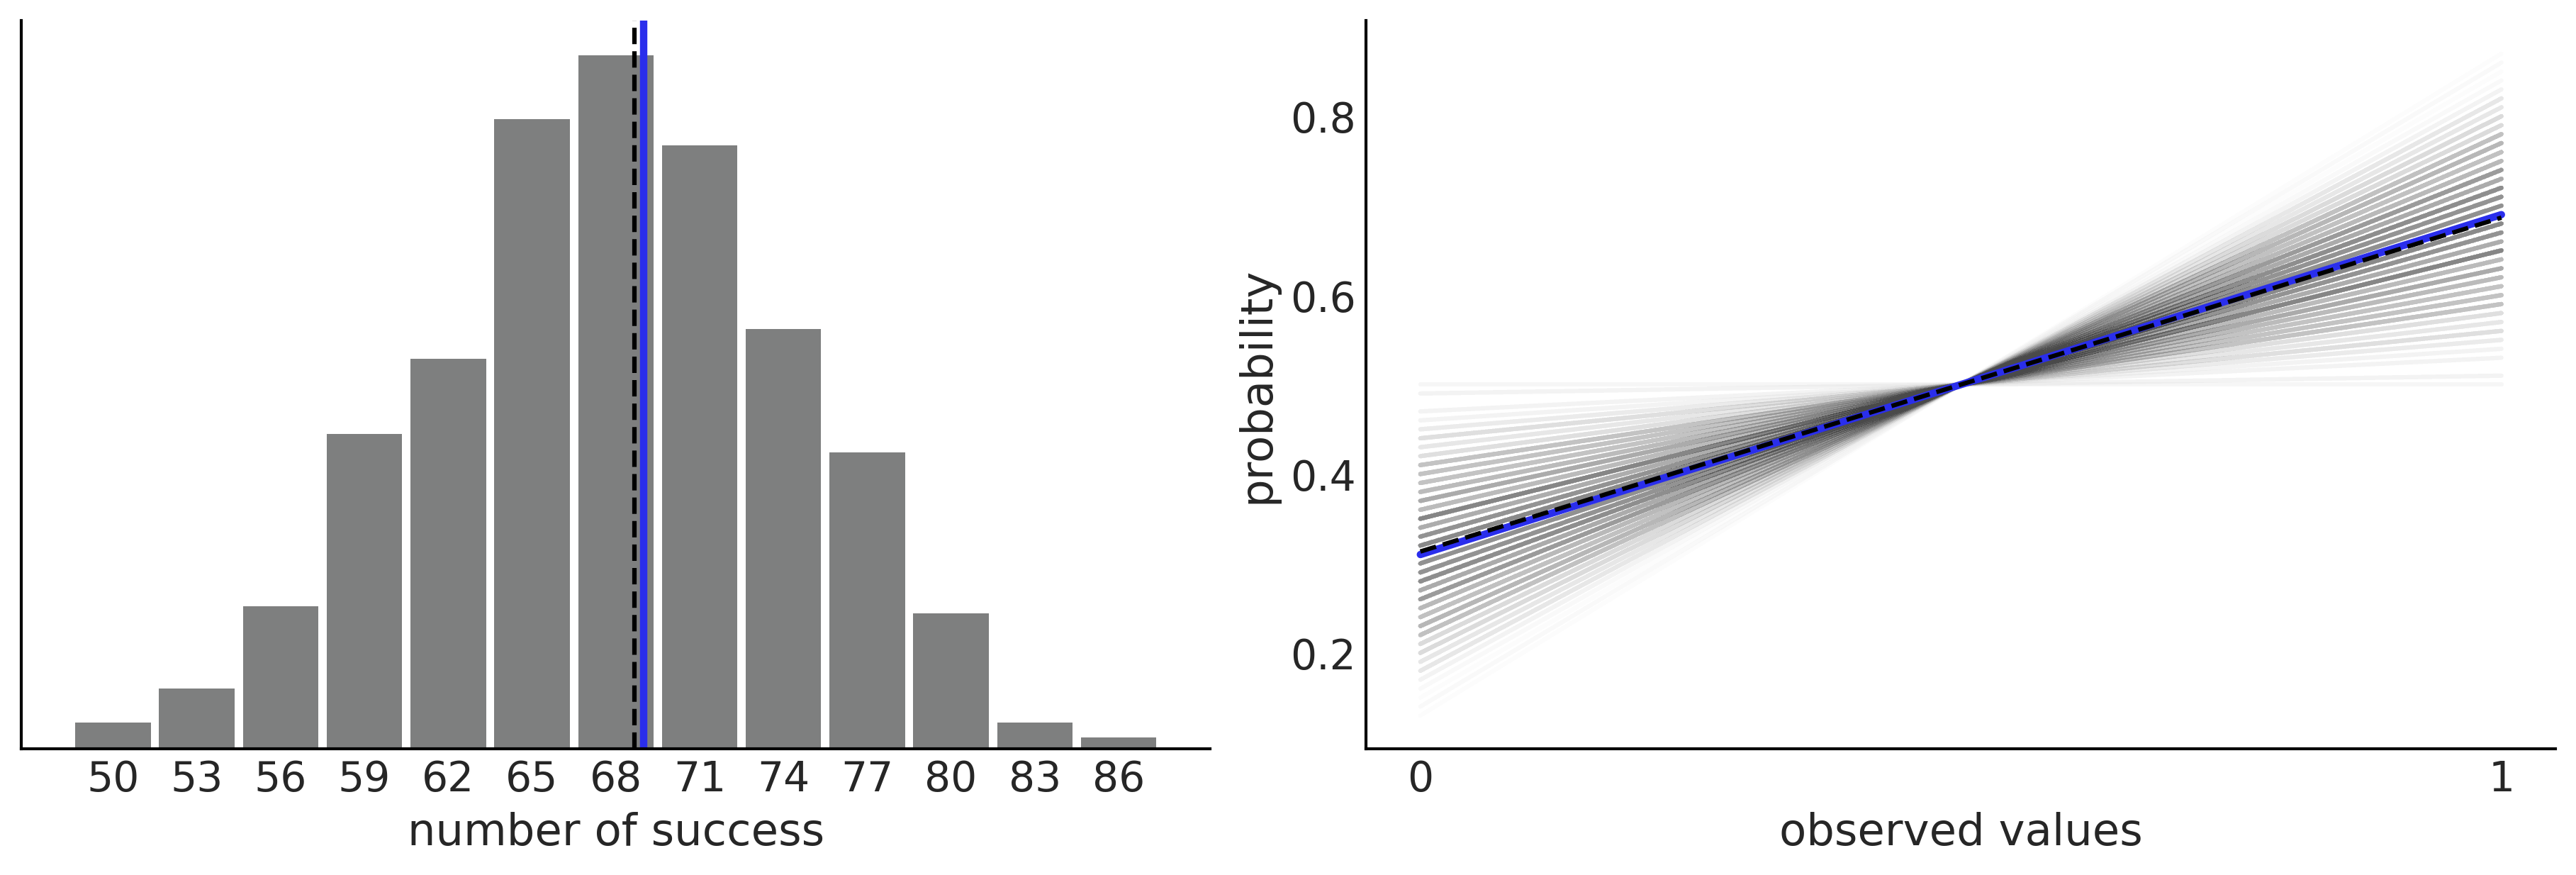

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(1),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5);
ax[0].axvline(pred_dist.sum(1).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")

pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.01)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")
plt.savefig("img/chp02/posterior_predictive_check.png")

In [9]:
idata = az.from_dict(posterior_predictive={"y":pred_dist.reshape(2, 500, 100)}, observed_data={"y":Y})

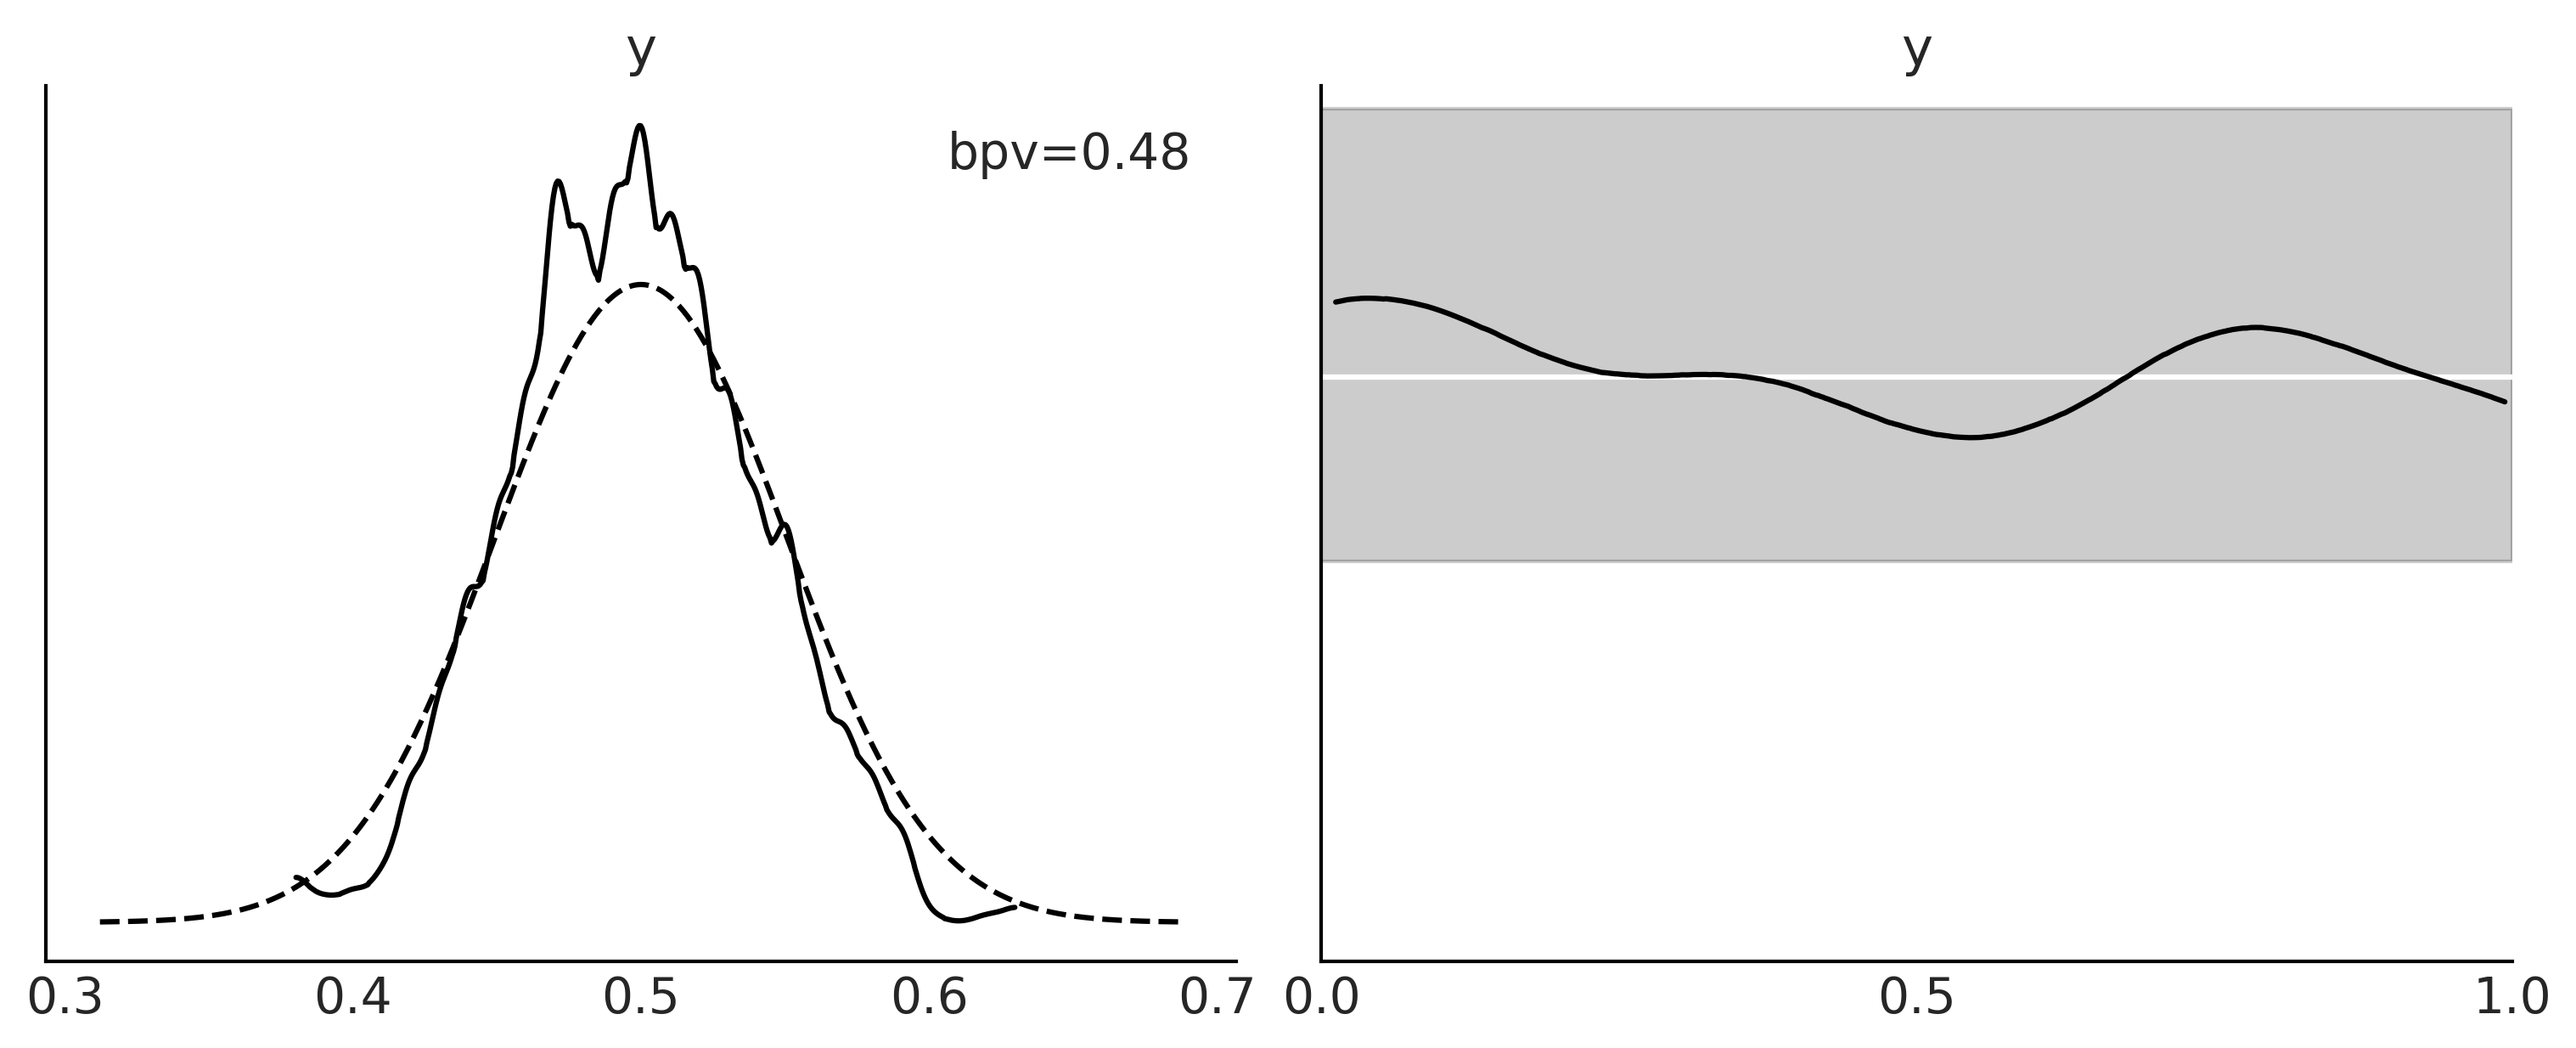

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])
plt.savefig("img/chp02/posterior_predictive_check_pu_values.png")

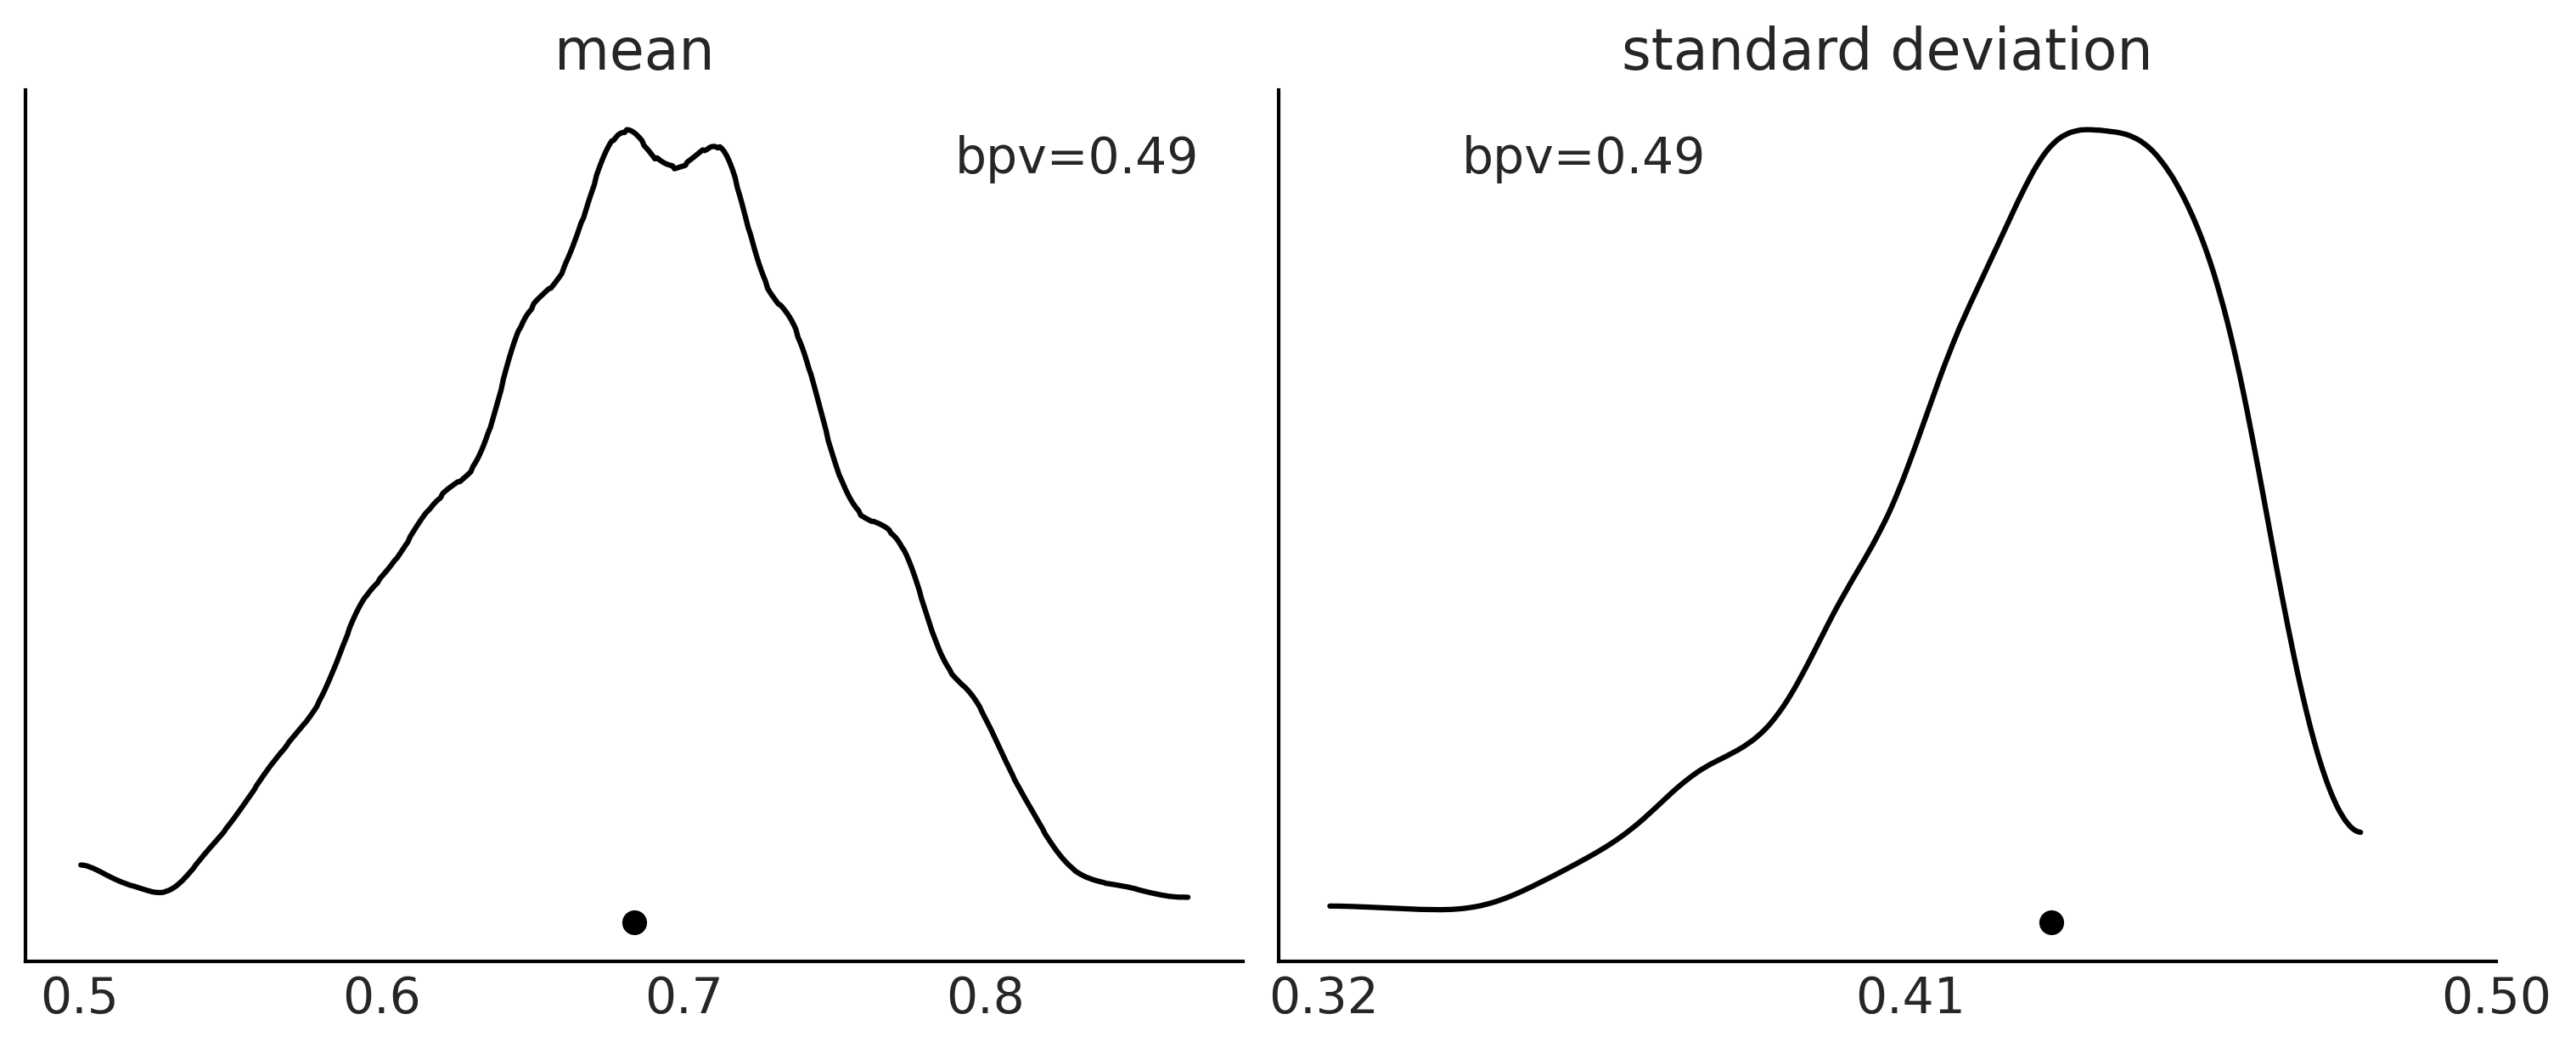

In [11]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=ax[0])
ax[0].set_title("mean")
az.plot_bpv(idata, kind="t_stat", t_stat="std", ax=ax[1])
ax[1].set_title("standard deviation")
ax[1].set_xticks([0.32, 0.41, 0.5])
plt.savefig("img/chp02/posterior_predictive_check_tstat.png")

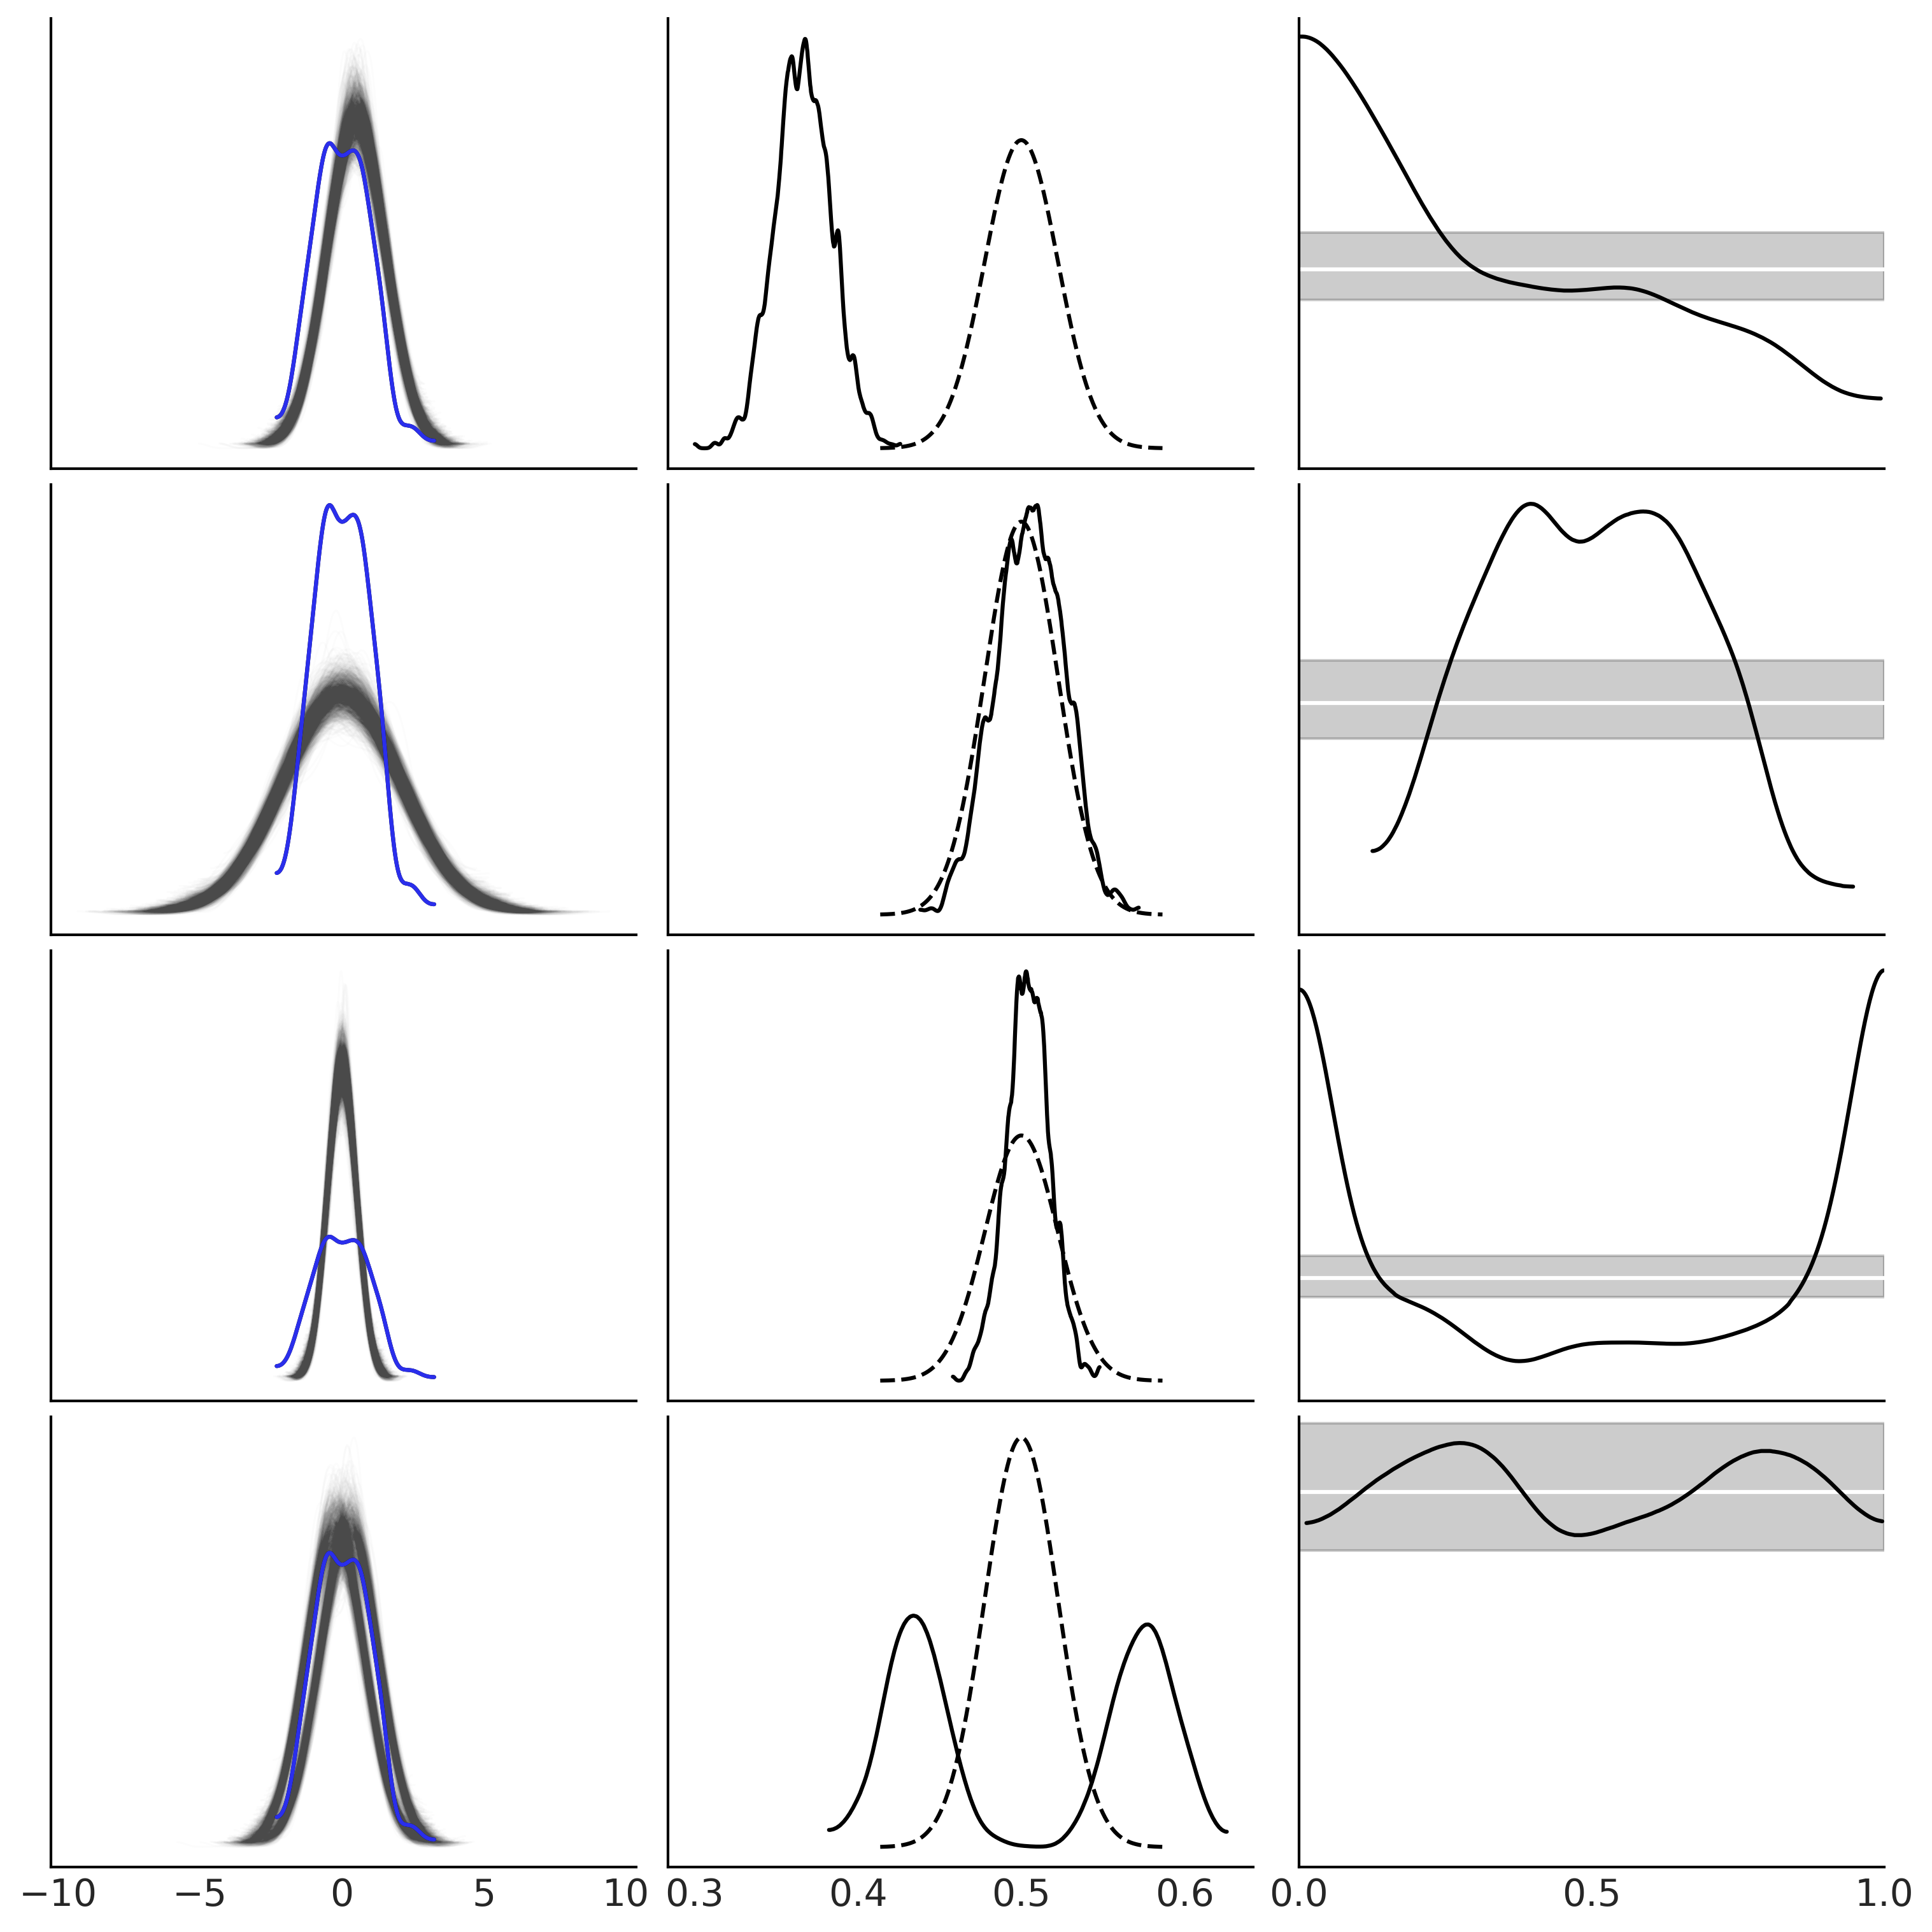

In [12]:
n_obs = 500
samples = 2000
y_obs = np.random.normal(0, 1, size=n_obs)

idata1 = az.from_dict(posterior_predictive={"y":np.random.normal(0.5, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata2 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 2, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata3 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 0.5, size=(1, samples,n_obs))},
                      observed_data={"y":y_obs})

idata4 = az.from_dict(posterior_predictive={"y":np.concatenate(
                                                [np.random.normal(-0.25, 1, size=(1, samples//2, n_obs)),
                                                 np.random.normal(0.25, 1, size=(1, samples//2, n_obs))]
                                                                )},
                      observed_data={"y":y_obs})

idatas = [idata1,
          idata2,
          idata3,
          idata4,
]

_, axes = plt.subplots(len(idatas), 3, figsize=(10, 10), sharex="col")

for idata, ax in zip(idatas, axes):
    az.plot_ppc(idata, ax=ax[0], color="C1", alpha=0.01, mean=False, legend=False)
    az.plot_kde(idata.observed_data["y"], ax=ax[0], plot_kwargs={"color":"C4", "zorder":3})                         
    ax[0].set_xlabel("")
    az.plot_bpv(idata, kind="p_value", ax=ax[1])
    az.plot_bpv(idata, kind="u_value", ax=ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([0., 0.5, 1.])
    for ax_ in ax:
        ax_.set_title("")

plt.savefig("img/chp02/posterior_predictive_many_examples.png")